<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Lecture 7: Gaussian Discriminant Analysis

### CS6364/CS4364 Machine Learning
__Sardar Hamidian__<br>The George Washington Universiry

__Armin Mehrabian__<br>The George Washington Universiry

# Announcements

* Homework 1 coming soon
* Start communicating us about your final project plans

# Part 1: Revisiting Generative Models

In the previous lecture, we introduced generative modeling and Naive Bayes.

We will start with a review and a motivating problem.

# Review: Discriminative vs. Generative Models

A probabilistic discriminative model outputs a vector of class probabilities

$$
\underbrace{\left[ 
\begin{array}{c}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\end{array}
\right]}_\text{input}
{\to}\text{model $P_\theta(y|x)$}{\to}
\underbrace{\left[ 
\begin{array}{c}
0.1 \\
0.7 \\
0.2 \\
\end{array}
\right]}_\text{output}
$$

The model takes $x$ to be a fixed input.

For example, logistic regression is a binary classification algorithm which uses a model 
$$f_\theta : \mathcal{X} \to [0,1]$$ 
of the form
$$ f_\theta(x) = \sigma(\theta^\top x) = \frac{1}{1 + \exp(-\theta^\top x)}, $$
where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the *sigmoid* or *logistic* function.

The logistic model defines ("parameterizes") a probability distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$ as follows:

\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}

Logistic regression optimizes the following objective defined over a binary classification dataset  $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.
\begin{align*}
\ell(\theta) & = \frac{1}{n}\sum_{i=1}^n \log P_\theta (y^{(i)} \mid x^{(i)}) \\
& = \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \cdot \log \sigma(\theta^\top x^{(i)}) + (1-y^{(i)}) \cdot \log (1-\sigma(\theta^\top x^{(i)})).
\end{align*}

This objective is also often called the log-loss, or cross-entropy.

This asks the model to ouput a large score $\sigma(\theta^\top x^{(i)})$ (a score that's close to one) if $y^{(i)}=1$, and a score that's small (close to zero) if $y^{(i)}=0$.

Generative models instead define a __joint__ distribution $P_\theta(x,y)$ over $x,y$.

# Generative Models: Intuition

Another approach to classification is to use *generative* models.

* A generative approach first builds a model of $x$ for each class:
$$ P_\theta(x | y=k) \; \text{for each class $k$}.$$
$P_\theta(x | y=k)$ *scores* each $x$ according to how well it matches class $k$.

* A class probability $P_\theta(y=k)$ encoding our prior beliefs.
These are often just the % of each class in the data.

In the context of spam classification, we would fit two models on a corpus of emails $x$ with spam/non-spam labels $y$:

\begin{align*}
P_\theta(x|y=\text{0}) && \text{and} && P_\theta(x|y=\text{1})
\end{align*}

* $P_\theta(x | y=1)$ *scores* each $x$ based on how much it looks like spam.
* $P_\theta(x | y=0)$ *scores* each $x$ based on whether it looks like non-spam.

We also choose a prior $P(y)$.

In the context of spam classification, given a new $x'$, we would compare the probabilities of both models:

\begin{align*}
P_\theta(x'|y=\text{0})P_\theta(y=\text{0}) && \text{vs.} && P_\theta(x'|y=\text{1})P_\theta(y=\text{1})
\end{align*}

We output the class that's more likely to have generated $x'$.

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 2: Gaussian Mixture Models

Next, we will define another generative model: Gaussian mixtures.

# The Iris Flowers Dataset

As a motivating problem for this lecture, we are going to use the Iris flower dataset ([R. A. Fisher, 1936](https://en.wikipedia.org/wiki/Ronald_Fisher)).

Recall that our task is to classify subspecies of Iris flowers based on their measurements.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


If we only consider the first two feature columns, we can visualize the dataset in 2D.

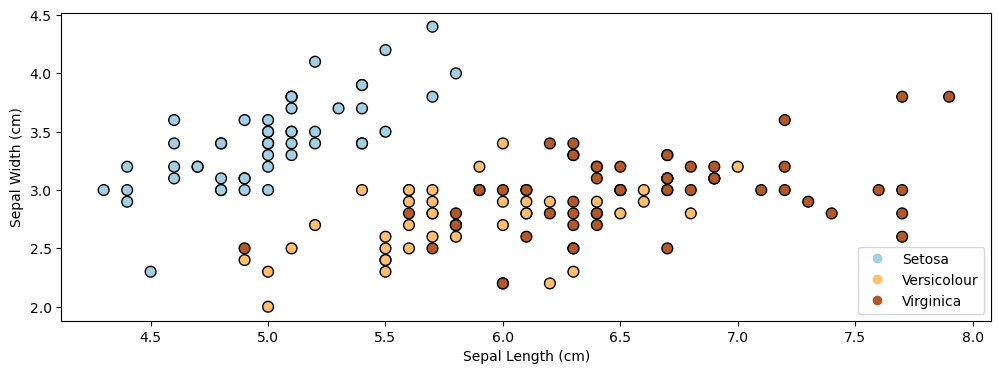

In [2]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# create 2d version of dataset
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')

Let's train logistic/softmax regression on this dataset.

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

# Create an instance of Logistic Regression Classifier and fit the data.
X = iris_X.to_numpy()[:,:2]
# rename class two to class one
Y = iris_y.copy()
logreg.fit(X, Y) 

LogisticRegression(C=100000.0)

We visualize the regions predicted to be associated with the blue, brown, and yellow classes and the lines between them are the decision boundaries.

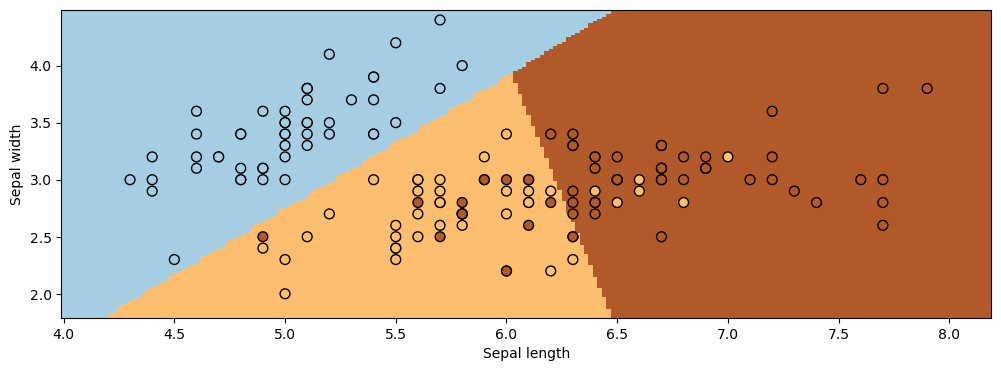

In [4]:
xx, yy = np.meshgrid(np.arange(4, 8.2, .02), np.arange(1.8, 4.5, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

# A Generative Model for Iris Flowers

To define a generative model for Iris flowers, we need to define three probabilities:

\begin{align*}
P_\theta(x|y=\text{0}) && P_\theta(x|y=\text{1}) && P_\theta(x|y=\text{2})
\end{align*}

We also define priors $P_\theta(y=\text{0}), P_\theta(y=\text{1}), P_\theta(y=\text{2})$.

How do we choose $P_\theta(x|y=k)$ and $P_\theta(y)$?

# Review: Categorical Distribution

A [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution) distribution with parameters $\theta$ is a probability
over $K$ discrete outcomes $x \in \{1,2,...,K\}$:

$$
P_\theta(x = j) = \theta_j.
$$

When $K=2$ this is called the [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution).

# Review: Normal (Gaussian) Distribution

A [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution with parameters $\theta = (\mu, \Sigma)$
is a probability over a $d$-dimensional $x \in \mathbb{R}^d$

$$
P_\theta(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^d | \Sigma |}} \exp\left(-\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x-\mu) \right)
$$

In one dimension, this reduces to $\frac{1}{\sqrt{2 \pi}\sigma} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} \right)$.

This what the density of a 2D Normal distribution looks like in 3D:


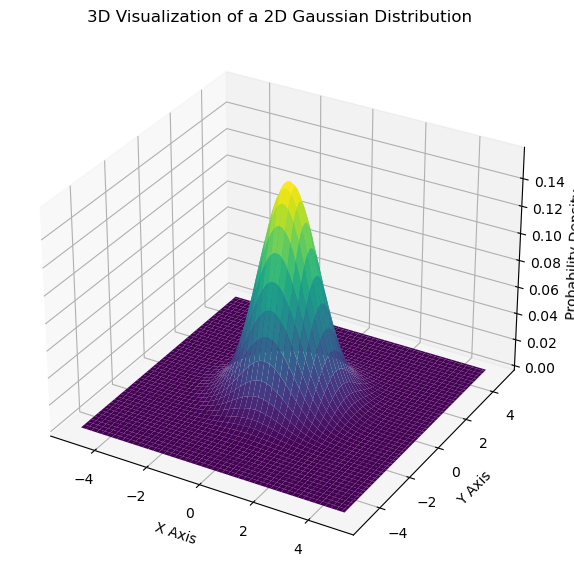

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Mean and Covariance matrix for the 2D Gaussian
mean = np.array([0, 0])
cov_matrix = np.array([[1, 0], [0, 1]])

# Create a grid of (x, y) values
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))

# Create a 2D Gaussian Distribution with the given mean and covariance
rv = multivariate_normal(mean, cov_matrix)

# Compute the values of the Gaussian at each grid point
z = rv.pdf(pos)

# Set up the plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis', linewidth=0)

# Set labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Probability Density')

plt.title('3D Visualization of a 2D Gaussian Distribution')

# Show the plot
plt.show()


This is how we can visualize its marginal probabilities in a 2D planes:


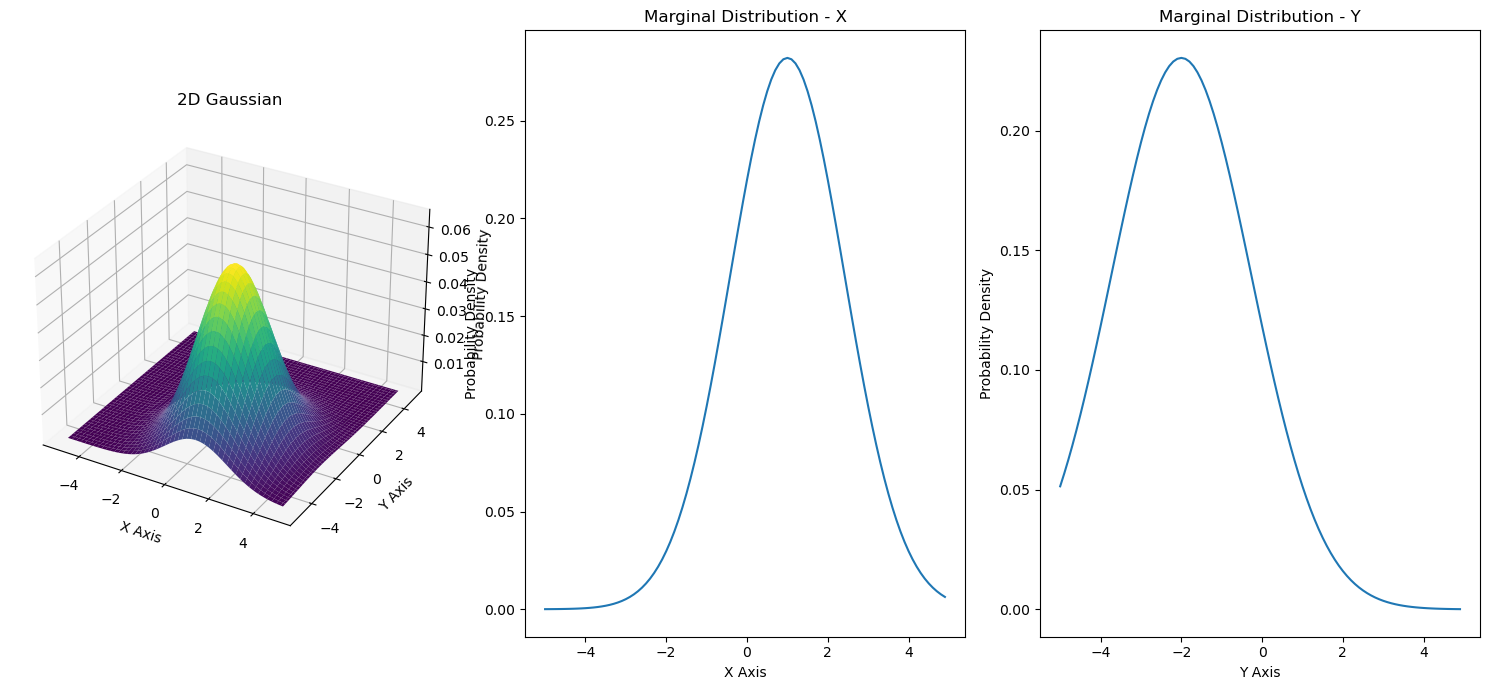

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, multivariate_normal

# Mean and Covariance matrix for the 2D Gaussian
mean = np.array([1, -2])  # Different mean for X and Y
cov_matrix = np.array([[2, 0], [0, 3]])  # Different variance for X and Y, no covariance

# Create a grid of (x, y) values
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))

# Create a 2D Gaussian Distribution with the given mean and covariance
rv = multivariate_normal(mean, cov_matrix)

# Compute the values of the Gaussian at each grid point
z = rv.pdf(pos)

# Set up the plot
fig = plt.figure(figsize=(15, 7))

# 3D Visualization of 2D Gaussian
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(x, y, z, cmap='viridis', linewidth=0)
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Probability Density')
ax1.title.set_text('2D Gaussian')

# Marginal Distribution of X
ax2 = fig.add_subplot(132)
ax2.plot(x[:, 0], norm.pdf(x[:, 0], loc=mean[0], scale=np.sqrt(cov_matrix[0, 0])))
ax2.title.set_text('Marginal Distribution - X')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Probability Density')

# Marginal Distribution of Y
ax3 = fig.add_subplot(133)
ax3.plot(y[0, :], norm.pdf(y[0, :], loc=mean[1], scale=np.sqrt(cov_matrix[1, 1])))
ax3.title.set_text('Marginal Distribution - Y')
ax3.set_xlabel('Y Axis')
ax3.set_ylabel('Probability Density')

plt.tight_layout()
plt.show()


# Gaussian Mixture Model

A *Gaussian mixture* model (GMM) $P_\theta(x,y)$ is defined for *real-valued data* $x \in \mathbb{R}^d$.

The $\theta$ contains prior parameters $\vec\phi = (\phi_1,...,\phi_K)$ and $K$ sets of per-class Gaussian parameters $\mu_k, \Sigma_k$.

The probability of the data $x$ for each class is a multivariate Gaussian
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma_k).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

# Gaussian Mixture Model: Intuition

Fitting a GMM model amounts to fitting one Gaussian per class.


At test time, we predict the class of the Gaussian that is most likely to have generated the data.

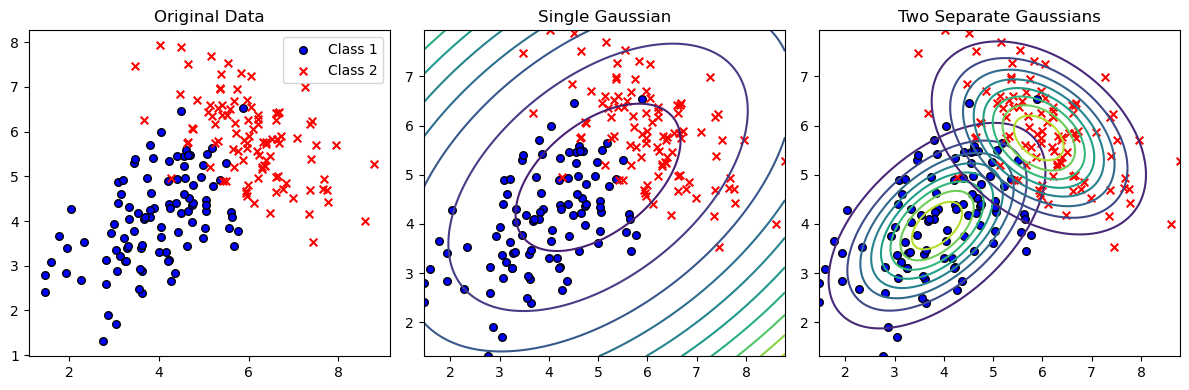

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

# Generate synthetic data
np.random.seed(0)
mean_one, cov_one = [4, 4], [[1, 0.5], [0.5, 1]]
mean_two, cov_two = [6, 6], [[1, -0.5], [-0.5, 1]]
data_one = np.random.multivariate_normal(mean_one, cov_one, 100)
data_two = np.random.multivariate_normal(mean_two, cov_two, 100)

# Plot the original data without any Gaussian
plt.subplot(1, 3, 1)
plt.scatter(data_one[:, 0], data_one[:, 1], c='blue', s=30, marker='o', edgecolor='k', label='Class 1')
plt.scatter(data_two[:, 0], data_two[:, 1], c='red', s=30, marker='x', edgecolor='k', label='Class 2')
plt.title('Original Data')
plt.legend()

# Combine the data and fit a single Gaussian to the data
data_combined = np.concatenate([data_one, data_two])
gmm_single = GaussianMixture(n_components=1, covariance_type='full').fit(data_combined)

a = np.linspace(np.min(data_combined[:, 0]), np.max(data_combined[:, 0]), num=100)
b = np.linspace(np.min(data_combined[:, 1]), np.max(data_combined[:, 1]), num=100)
A, B = np.meshgrid(a, b)
AB = np.array([A.ravel(), B.ravel()]).T
Z_single = -gmm_single.score_samples(AB)
Z_single = Z_single.reshape(A.shape)

# Plot the data with single Gaussian contour
plt.subplot(1, 3, 2)
plt.scatter(data_one[:, 0], data_one[:, 1], c='blue', s=30, marker='o', edgecolor='k')
plt.scatter(data_two[:, 0], data_two[:, 1], c='red', s=30, marker='x', edgecolor='k')
plt.contour(A, B, Z_single, levels=10)
plt.title('Single Gaussian')

# Fit two Gaussians to the data
gmm_double = GaussianMixture(n_components=2, covariance_type='full').fit(data_combined)

# Plot the data with contours for each Gaussian separately
plt.subplot(1, 3, 3)
plt.scatter(data_one[:, 0], data_one[:, 1], c='blue', s=30, marker='o', edgecolor='k')
plt.scatter(data_two[:, 0], data_two[:, 1], c='red', s=30, marker='x', edgecolor='k')

for i in range(gmm_double.n_components):
    Z_double = multivariate_normal.pdf(AB, mean=gmm_double.means_[i], cov=gmm_double.covariances_[i])
    Z_double = Z_double.reshape(A.shape)
    plt.contour(A, B, Z_double, levels=np.linspace(Z_double.min(), Z_double.max(), 10))

plt.title('Two Separate Gaussians')
plt.tight_layout()
plt.show()


Given a new flower $x'$, we would compare the probabilities of three models:

\begin{align*}
P_\theta(x'|y=\text{0})P_\theta(y=\text{0}) \\ P_\theta(x'|y=\text{1})P_\theta(y=\text{1}) \\ P_\theta(x'|y=\text{2})P_\theta(y=\text{2})
\end{align*}

We output the class that's more likely to have generated $x'$.

# Why Mixtures of Distributions?

A single distribution (e.g., a Gaussian) can be too simple to fit the data. We can form more complex distributions by *mixing* $K$ simple ones:

$$ P_\theta(x) = \phi_1 P_1(x ;\theta_1) + \phi_2 P_2(x ;\theta_2) + \ldots + \phi_K P_K(x ;\theta_K) $$

where the $\phi_k \in [0,1]$ are the weights of each distribution.

A mixture of $K$ Gaussians is a distribution $P(x)$ of the form:
$$\phi_1 \mathcal{N}(x; \mu_1, \Sigma_1) + \phi_2 \mathcal{N}(x; \mu_2, \Sigma_2) + \ldots + \phi_K \mathcal{N}(x; \mu_K, \Sigma_K).$$

# GMMs Are Indeed Mixtures

The Gaussian Mixture Model is an example of a mixture of $K$ distributions with mixing weights $\phi_k = P(y=k)$:
$$P_\theta(x) = \sum_{k=1}^K P_\theta(y=k) P_\theta(x|y=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

Mixtures of Gaussians fit more complex distributions than one Gaussian.


<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 3: Gaussian Discriminant Analysis

Next, we will use GMMs as the basis for a new generative classification algorithm, Gaussian Discriminant Analysis (GDA).

# Review: Gaussian Mixture Model

We may define a model $P_\theta$ as follows. This will be the basis of an algorthim called Gaussian Discriminant Analysis.
* The distribution over classes is [Categorical](https://en.wikipedia.org/wiki/Categorical_distribution), denoted $\text{Categorical}(\phi_1, \phi_2, ..., \phi_K)$. Thus, $P_\theta(y=k) = \phi_k$.
* The conditional probability $P(x\mid y=k)$ of the data under class $k$ is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) $\mathcal{N}(x; \mu_k, \Sigma_k)$ with mean and covariance $\mu_k, \Sigma_k$.

Thus, $P_\theta(x,y)$ is a mixture of $K$ Gaussians:
$$P_\theta(x,y) = \sum_{k=1}^K P_\theta(y=k) P_\theta(x|y=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

# Review: Maximum Likelihood Learning

We can learn a generative model $P_\theta(x, y)$ by maximizing the *maximum likelihood*:

$$ \max_\theta \sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)}). $$

This seeks to find parameters $\theta$ such that the model assigns high probability to the training data.

Let's use maximum likelihood to fit a Gaussian mixture model. Note that model parameterss $\theta$ are the union of the parameters of each sub-model:
$$\theta = (\mu_1, \Sigma_1, \phi_1, \ldots, \mu_K, \Sigma_K, \phi_K).$$


Mathematically, the components of the model $P_\theta(x,y)$ are as follows.
\begin{align*}
P_\theta(y) & = \frac{\prod_{k=1}^K \phi_k^{\mathbb{I}\{y = y_k\}}}{\sum_{k=1}^k \phi_k} \\
P_\theta(x|y=k) & = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu_k)^\top\Sigma_k^{-1}(x-\mu_k))
\end{align*}

# Optimizing the Log Likelihood

Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\mid i=1,2,\ldots,n\}$, we want to optimize the log-likelihood $\ell(\theta)$:
\begin{align*}
\ell(\theta) & = \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)}) = \sum_{i=1}^n \log P_\theta(x^{(i)} | y^{(i)}) + \sum_{i=1}^n \log P_\theta(y^{(i)})
\end{align*}

\begin{align*}
\;\; & = \sum_{k=1}^K  \underbrace{\sum_{i : y^{(i)} = k} \log P(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k)}_\text{all the terms that involve $\mu_k, \Sigma_k$} + \underbrace{\sum_{i=1}^n \log P(y^{(i)} ; \vec \phi)}_\text{all the terms that involve $\vec \phi$}.
\end{align*}

In equality #2, we use the fact that $P_\theta(x,y)=P_\theta(y) P_\theta(x|y)$; in the third one, we change the order of summation.

Each $\mu_k, \Sigma_k$ for $k=1,2,\ldots,K$ is found in only the following terms:
\begin{align*}
\max_{\mu_k, \Sigma_k} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)})
& = \max_{\mu_k, \Sigma_k} \sum_{l=1}^K  \sum_{i : y^{(i)} = l} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_l, \Sigma_l) \\
& = \max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log P_\theta(x^{(i)} | y^{(i)} ; \mu_k, \Sigma_k).
\end{align*}
Thus, optimization over $\mu_k, \Sigma_k$ can be carried out independently of all the other parameters by just looking at these terms.

Similarly, optimizing for $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$ only involves a few terms:
$$ \max_{\vec \phi} \sum_{i=1}^n \log P_\theta(x^{(i)}, y^{(i)} ; \theta) = \max_{\vec\phi} \
\sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi). $$

# Learning the Parameters $\phi$

Let's first consider the optimization over $\vec \phi = (\phi_1, \phi_2, \ldots, \phi_K)$. 
$$ \max_{\vec \phi} \sum_{i=1}^n  \log P_\theta(y=y^{(i)} ; \vec \phi). $$
* We have $n$ datapoints. Each point has a label $k\in\{1,2,...,K\}$.
* Our model is a categorical and assigns a probability $\phi_k$ to each outcome $k\in\{1,2,...,K\}$.
* We want to infer $\phi_k$ assuming our dataset is sampled from the model.

What are the maximum likelihood $\phi_k$ that are most likely to have generated our data?

Inuitively, the maximum likelihood class probabilities $\phi$ should just be the class proportions that we see in the data. 

Let's calculate this formally. Our objective $J(\vec \phi)$ equals
\begin{align*}
J(\vec\phi) & = \sum_{i=1}^n  \log P_\theta(y^{(i)} ; \vec \phi) \\
& = \sum_{i=1}^n \log \phi_{y^{(i)}} - n \cdot \log \sum_{k=1}^K \phi_k \\ 
& = \sum_{k=1}^K \sum_{i : y^{(i)} = k} \log \phi_k - n \cdot \log \sum_{k=1}^K \phi_k
\end{align*}

Taking the derivative and setting it to zero, we obtain the following necessary condition
$$ \frac{\phi_k}{\sum_l \phi_l} = \frac{n_k}{n}$$
for each $k$, where $n_k = |\{i : y^{(i)} = k\}|$ is the number of training targets with class $k$.

Thus, the optimal $\phi_k$ is just the proportion of data points with class $k$ in the training set!

# Learning the Parameters $\mu_k, \Sigma_k$

Next, let's look at the maximum likelihood term
$$\max_{\mu_k, \Sigma_k} \sum_{i : y^{(i)} = k} \log \mathcal{N}(x^{(i)} | \mu_k, \Sigma_k)$$
over the Gaussian parameters $\mu_k, \Sigma_k$.

* Our dataset are all the points $x$ for which $y=k$.
* We want to learn the mean and variance $\mu_k, \Sigma_k$ of a normal distribution that generates this data.

What is the maximum likelihood $\mu_k, \Sigma_k$ in this case?

Computing the derivative and setting it to zero, we obtain closed form solutions:
\begin{align*}
\mu_k & = \frac{\sum_{i: y^{(i)} = k} x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i: y^{(i)} = k} (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
\end{align*}
These are just the empirical means and covariances of each class.

# Querying the Model

How do we ask the model for predictions? As discussed earler, we can apply Bayes' rule:
$$\arg\max_y P_\theta(y|x) = \arg\max_y P_\theta(x|y)P(y).$$
Thus, we can estimate the probability of $x$ and under each $P_\theta(x|y=k)P(y=k)$ and choose the class that explains the data best.

# Algorithm: Gaussian Discriminant Analysis (GDA)

* __Type__: Supervised learning (multi-class classification)
* __Model family__: Mixtures of Gaussians.
* __Objective function__: Log-likelihood.
* __Optimizer__: Closed form solution.

# Example: Iris Flower Classification

Let's see how this approach can be used in practice on the Iris dataset.
* We will learn the maximum likelihood GDA parameters
* We will compare the outputs to the true predictions.

Let's first start by computing the true parameters on our dataset.

In [15]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(f" Means (mus) are {mus}\n")

# print the Sigmas
print(f" Covariances (Sigmas) are {Sigmas}")

 Means (mus) are [[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]

 Covariances (Sigmas) are [[[0.12424898 0.09921633]
  [0.09921633 0.1436898 ]]

 [[0.26643265 0.08518367]
  [0.08518367 0.09846939]]

 [[0.40434286 0.09376327]
  [0.09376327 0.10400408]]]


We can compute predictions using Bayes' rule.

In [9]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 1]


We visualize the decision boundaries like we did earlier.

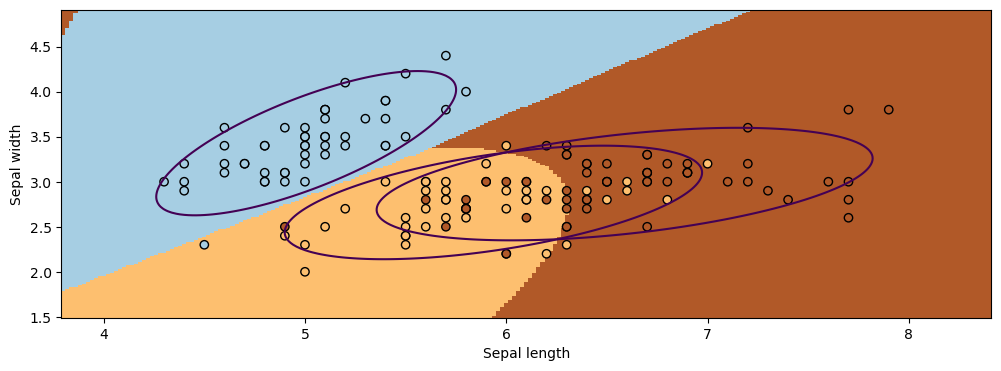

In [10]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

# Discriminative vs. Generative Algorithms

We conclude our lectures on generative algorithms by revisting the question of how they compare to discriminative algorithms.

# Discriminative Approaches

Discriminative algorithms are deservingly very popular.
* Most state-of-the-art algorithms for classification are discriminative (including neural nets, boosting, SVMs, etc.)
* They are often more accurate because they make fewer modeling assumptions.

# Other Useful Features of Generative Models

Generative models can also do things that discriminative models can't do.
* __Generation__: we can sample $x \sim p(x|y)$ to generate new data (images, audio).
* __Missing value imputation__: if $x_j$ is missing, we infer it using $p(x|y)$.
* __Outlier detection__: we may detect via $p(x')$ if $x'$ is an outlier.
* __Scalability__: Simple formulas for maximum likelihood parameters.

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Appendix: 
* Special Cases of GDA (LDA, QNB, QDA)
* LDA vs. Logistic Regression


# Special Cases of GDA

Many important generative algorithms are special cases of Gaussian Discriminative Analysis
* Linear discriminant analysis (LDA): all the covariance matrices $\Sigma_k$ take the same value.
* Gaussian Naive Bayes: all the covariance matrices $\Sigma_k$ are diagonal.
* Quadratic discriminant analysis (QDA): another term for GDA.

# Linear Discriminant Analysis

When the covariances $\Sigma_k$ in GDA are equal, we have an algorithm called Linear Discriminant Analysis or LDA.

The probability of the data $x$ for each class is a multivariate Gaussian with the same covariance $\Sigma$.
$$P_\theta(x|y=k) = \mathcal{N}(x ; \mu_k, \Sigma).$$

The probability over $y$ is Categorical:
$P_\theta(y=k) = \phi_k$.

Let's try this algorithm on the Iris flower dataset.

We compute the model parameters similarly to how we did for GDA.

In [11]:
# we can implement these formulas over the Iris dataset
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X.T) # this is now X.T instead of X_k.T
    phis[k] = X_k.shape[0] / float(n)

# print out the means
print(mus)

[[5.006 3.428]
 [5.936 2.77 ]
 [6.588 2.974]]


We can compute predictions using Bayes' rule.

In [12]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)
print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 1 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


We visualize predictions like we did earlier.

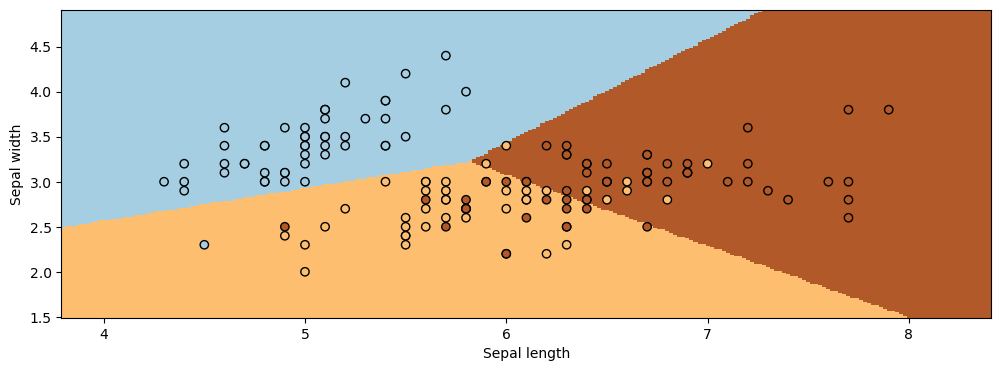

In [13]:
from matplotlib.colors import LogNorm
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

Linear Discriminant Analysis outputs decision boundaries that are linear, just like Logistic/Softmax Regression.

Softmax or Logistic regression also produce linear boundaries. In fact, both types of algorithms make use of the same model class.

Are the algorithms equivalent?

# What Is the LDA Model Class?

We can derive a formula for $P_\theta(y|x)$ in a Bernoulli Naive Bayes or LDA model when $K=2$:
$$ P_\theta(y|x) = \frac{P_\theta(x|y)P_\theta(y)}{\sum_{y'\in \mathcal{Y}}P_\theta(x|y')P_\theta(y')} = \frac{1}{1+\exp(-\gamma^\top x)} $$
for some set of parameters $\gamma$ (whose expression can be derived from $\theta$). 

This is the same form as Logistic Regression! Does it mean that the two sets of algorithms are equivalent? 

No! They assume the same model class $\mathcal{M}$, they use a different objective $J$ to select a model in $\mathcal{M}$.

# LDA vs. Logistic Regression

What are the differences between LDA/NB and logistic regession?

* Bernoulli Naive Bayes or LDA assumes a logistic form for $P(y|x)$. But the converse is not true: logistic regression does not assume a NB or LDA model for $P(x,y)$.

* Generative models make stronger modeling assumptions. If these assumptions hold true, the generative models will perform better.

* But if they don't, logistic regression will be more robust to outliers and model misspecification, and achieve higher accuracy.